In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import warnings
warnings.filterwarnings('ignore')

import torchvision.transforms as tr
import matplotlib.pyplot as plt
#from src.models import octave_cloud_shadow_classifier, cloud_shadow_double_classifier, rotate_c
from equiv_net import EquivariantNet, load_checkpoint

In [2]:
def show(x):
    plt.imshow(x[0].permute(1,2,0).detach().numpy())

In [3]:
def get_rot_mat(theta):
    theta = torch.tensor(theta)
    return torch.tensor([[torch.cos(theta), -torch.sin(theta), 0],
                         [torch.sin(theta), torch.cos(theta), 0]])


def rot_img(x, theta):
    rot_mat = get_rot_mat(theta)[None, ...].repeat(x.shape[0],1,1)
    grid = F.affine_grid(rot_mat, x.size()).float()
    x = F.grid_sample(x, grid)
    return x

In [14]:
class EquivarianceTester:
    def __init__(self, use_conv=True):
        self.use_conv = use_conv
    
    def plot_block(self):
        max_val = max(np.abs(self.all_x).max(), np.abs(self.all_y).max())
        fig, axs = plt.subplots(2, 3, figsize = (18,12))
        axs[0,0].scatter(self.all_x, self.all_y)
        axs[0,0].set_xlim(-max_val,max_val)
        axs[0,0].set_ylim(-max_val,max_val)
        axs[0,0].set_title("Generated points")

        axs[0,1].plot(self.all_x, self.all_y)
        axs[0,1].set_xlim(-max_val,max_val)
        axs[0,1].set_ylim(-max_val,max_val)
        axs[0,1].set_title("Generated trajectory")

        axs[0,2].plot(self.cos_pred, self.sin_pred)
        axs[0,2].set_xlim(-1,1)
        axs[0,2].set_ylim(-1,1)
        axs[0,2].set_title("Normalized trajectory")

        axs[1,0].plot(self.gt_cos)
        axs[1,0].plot(self.pred_cos_corrected)
        axs[1,0].set_title("GT cosine vs Pred cosine")

        axs[1,1].plot(self.gt_sin)
        axs[1,1].plot(self.pred_sin_corrected)
        axs[1,1].set_title("GT sine vs Pred sine")

        axs[1,2].plot(self.dist)
        axs[1,2].set_title("Distance")

    
    def test_rotation(self, model):
        x = torch.zeros(1, 3, 128, 128)
        x[:, :, 8:24, 8:24] = torch.randn(1, 1, 16, 16).float()
        kernel_x = torch.tensor([[-1,0,1], [-2,0,2], [-1,0,1]]).reshape(1,1,3,3).float()
        kernel_y = torch.tensor([[1,2,1], [0,0,0], [-1,-2,-1]]).reshape(1,1,3,3).float()

        self.all_x, self.all_y, self.angles = [], [], []

        for angle in np.linspace(0, 2*np.pi,num=2**6+1):
            self.angles.append(angle)
            x_new = rot_img(x, angle)
            y = model(x_new)
            if self.use_conv:
                y_x = F.conv2d(y, kernel_x, padding=1).mean()
                y_y = F.conv2d(y, kernel_y, padding=1).mean()
            else:
                y_x, y_y = y[0, 0], y[0, 1]
            self.all_x.append(y_x.item())
            self.all_y.append(y_y.item())
        self.all_x, self.all_y = np.array(self.all_x), np.array(self.all_y)
        leng = np.sqrt(self.all_x**2 + self.all_y**2)
        self.cos_pred, self.sin_pred = self.all_x / leng, self.all_y / leng
        alg = np.arctan2(self.sin_pred[0], self.cos_pred[0])

        self.gt_cos = np.cos(np.array(self.angles))
        self.pred_cos_corrected = np.cos(np.arctan2(self.sin_pred, self.cos_pred) -alg)

        self.gt_sin = np.sin(np.array(self.angles))
        self.pred_sin_corrected = np.sin(np.arctan2(self.sin_pred, self.cos_pred) -alg)

        self.dist = np.sqrt((self.gt_cos - self.pred_cos_corrected)**2 + (self.gt_sin - self.pred_sin_corrected)**2)
        
        return self.dist.mean()
    
    def get_rotation_metric(self, model, num_repeats):
        dists = [self.test_rotation(model) for _ in range(num_repeats)]
        print('average distance: ', sum(dists) / len(dists))

In [6]:
model = EquivariantNet(2, 3, 'none')

In [5]:
model = load_checkpoint('test_models/815f516d-97ec-4ea3-a47b-65efa4dfd1b7.pth')

In [15]:
tester = EquivarianceTester(use_conv=False)

In [16]:
tester.get_rotation_metric(model, 1)

average distance:  0.801134104132634


In [26]:
tester.get_rotation_metric(model_usual, 1)

average distance:  1.2747493219944501


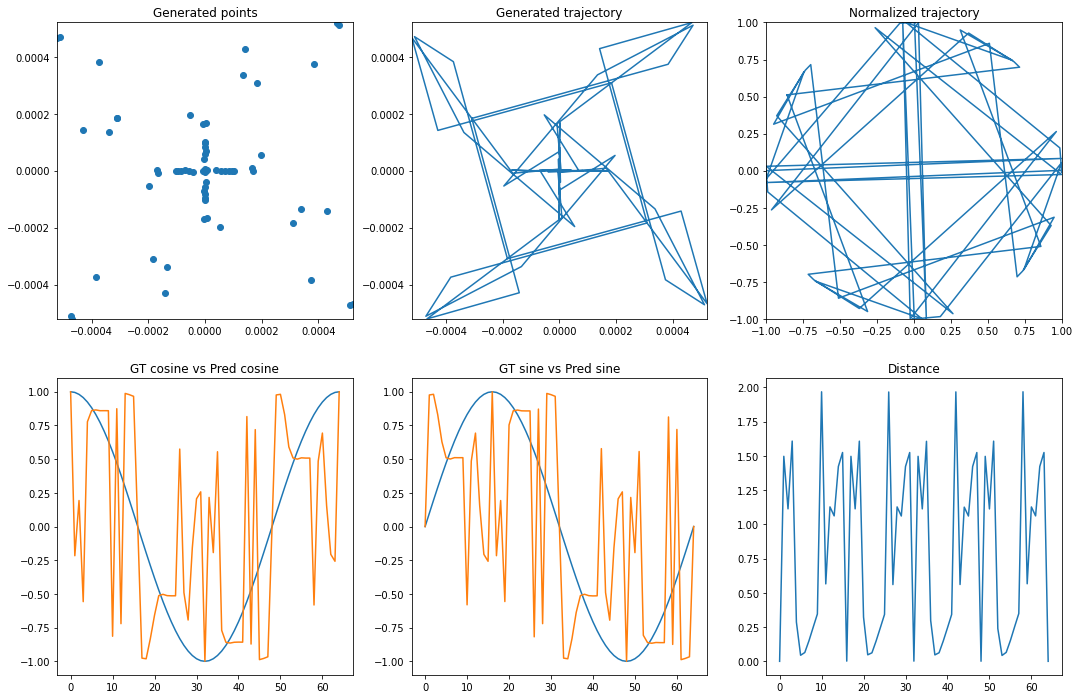

In [17]:
tester.plot_block()

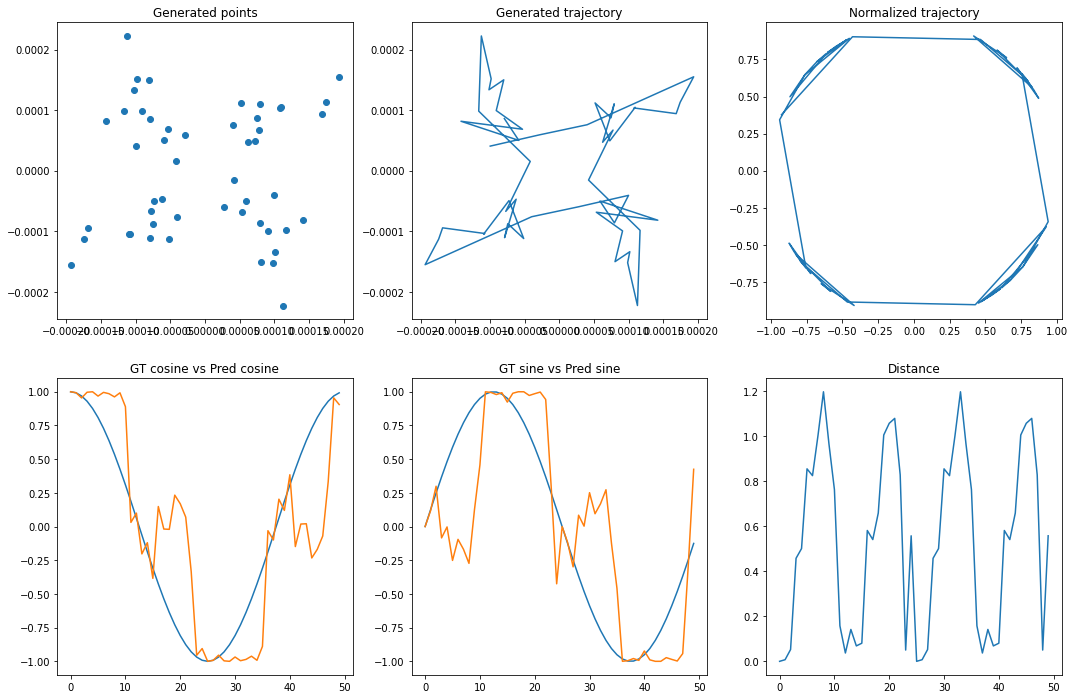

In [37]:
tester.plot_block()